In [1]:
using DelimitedFiles
using Distributions
using StatsBase
using Plots

action_space = [(0,0), (-1, 0), (1, 0), (0, -1), (0, 1), (1, 1), (-1, -1)]
speed_limit = 5

function next_state(racetrack, start_coord, state, action)
    x, y, vx, vy = state
    nx = x + vx
    ny = y + vy
    nvx = vx + action_space[action][1]
    nvy = vy +  action_space[action][2]
    reward = -1
    
    # can't go off the track
    if nx > size(racetrack)[1] || ny > size(racetrack)[2] || nx < 1 || ny < 1
        nx = start_coord[1]
        ny = start_coord[2]
        nvx = 0
        nvy = 0
        reward = -10
    elseif racetrack[nx, ny] == 1
        nx = start_coord[1]
        ny = start_coord[2]
        nvx = 0
        nvy = 0
        reward = -10
    end
    
    # can't go negative speed
    nvx > 0 || (nvx = 0)
    nvy > 0 || (nvy = 0)
    
    # can't go too fast
    nvx < speed_limit || (nvx = speed_limit)
    nvy < speed_limit || (nvy = speed_limit)
    
    racetrack[nx, ny] != 2 || (reward = 200.0)

    return (nx, ny, nvx, nvy), reward
end

mutable struct Policy
    state2action
    epsilon::Float64
end

random_action() = rand(1:length(action_space))

function randompolicy(track, ep=0.3)
    state2action = Array{Array{Float64, 1}, 4}(undef, size(track)[1], size(track)[2], speed_limit+1, speed_limit+1)
    for x in 1:size(track)[1]
        for y in 1:size(track)[2]
            for vx in 1:speed_limit+1
                for vy in 1:speed_limit+1
                    action = random_action()
                    state2action[x, y, vx, vy] = Array{Float64, 1}(undef, length(action_space))
                    for a in 1:length(action_space)
                        if a == action
                            state2action[x, y, vx, vy][a] = 1 - ep + (ep/length(action_space))  
                        else
                            state2action[x, y, vx, vy][a] = ep/length(action_space) 
                        end
                    end
                end
            end
        end
    end

    return state2action
end

usepolicy!(policy, state) = sample(1:length(action_space), Weights(policy[state[1], state[2], state[3]+1, state[4]+1]))
                    
function generate_episode(racetrack, start_coord, policy)
    last_state = (start_coord[1], start_coord[2], 0, 0)
    history = Array{Tuple{NTuple{4,Int64},Int64,Float64}, 1}(undef, 500000)
    step = 1
    while true
        action = usepolicy!(policy, last_state)
        state, reward = next_state(racetrack, start_coord, last_state, action)
        history[step] = (state, action, reward)
                                        
        last_state = state
        reward < 0 || break
        step < 500000 || (return generate_episode(racetrack, start_coord, policy))
        step += 1
    end
            
    return history, step
end

function load_racetrack(filepath)
    track = []
    open(filepath) do rt
        track = readdlm(rt, ',', Int8)
    end
    
    track = reverse(track; dims=1)
    
    start_coords = (0,0)
    for x in 1:size(track)[1]
        for y in 1:size(track)[2]
            v = track[x,y]
            if v == 3
                start_coords = (x, y)
            end
            print(v)
        end
        print("\n")
    end
    
    return track, start_coords
end

load_racetrack (generic function with 1 method)

In [2]:
function montecarlo_control(track, start_coords, iters=100, gamma=1.0, ep=0.3)
    values = []
    policy = randompolicy(track, ep)

    Q = ones(Float64, size(track)[1], size(track)[2], speed_limit+1, speed_limit+1, length(action_space)) * typemin(Float64)
    N = zeros(Float64, size(track)[1], size(track)[2], speed_limit+1, speed_limit+1, length(action_space))
    
    for i in 1:iters
        episode, step = generate_episode(track, start_coords, policy)
        
        # record the first visit to a state action pair
        seen = zeros(Int32, size(track)[1], size(track)[2], speed_limit+1, speed_limit+1, length(action_space))
        for t in 1:step
            state, action, reward = episode[t]
            if seen[state[1], state[2], state[3]+1, state[4]+1, action] == 0
                seen[state[1], state[2], state[3]+1, state[4]+1, action] = t
            end
        end

        value = 0
        for t in reverse(1:step)
            state, action, reward = episode[t]
            value = (value * gamma) + reward
            # is this the first visit?
            if seen[state[1], state[2], state[3]+1, state[4]+1, action] == t
                N[state[1], state[2], state[3]+1, state[4]+1, action] += 1.0
                # update Q towards the seen value of that action state pair
                Q[state[1], state[2], state[3]+1, state[4]+1, action] += (value - Q[state[1], state[2], state[3]+1, state[4]+1, action]) / N[state[1], state[2], state[3]+1, state[4]+1, action]
                
                # update policy to be max of Q
                val, oa = findmax(Q[state[1], state[2], state[3]+1, state[4]+1, 1:length(action_space)])
                
                for a in 1:length(action_space)
                    if a == oa
                        policy[state[1], state[2], state[3]+1, state[4]+1][a] = 1 - ep + (ep/length(action_space))
                    else
                        policy[state[1], state[2], state[3]+1, state[4]+1][a] = ep/length(action_space)
                    end
                    
                end
                
            end
        end
        
        append!(values, value)
        
        #policy.epsilon = policy.epsilon / 1.05
        
        print("*")
        flush(stdout)
    end
    
    return values
end

montecarlo_control (generic function with 4 methods)

In [3]:
function sarsa_control(track, start_coords, alpha=0.2, iters=100, gamma=1.0, ep=0.3)
    values = []
    value = -100
    policy = randompolicy(track, ep)

    Q = ones(Float64, size(track)[1], size(track)[2], speed_limit+1, speed_limit+1, length(action_space)) * typemin(Float64)
    
    for i in 1:iters 
        
        append!(values, value)
        value = 0
        
        state = (start_coords[1], start_coords[2], 0, 0)
        action = usepolicy!(policy, state)
        while true
            s_prime, reward = next_state(track, start_coords, state, action)
            value += reward
            
            a_prime = usepolicy!(policy, s_prime)

            #SARSA update step
            Q[state[1], state[2], state[3]+1, state[4]+1, action] += 
                alpha * 
                (reward + (gamma * Q[s_prime[1], s_prime[2], s_prime[3]+1, s_prime[4]+1, a_prime]) 
                    -  Q[state[1], state[2], state[3]+1, state[4]+1, action])

             # update policy to be max of Q
            val, oa = findmax(Q[state[1], state[2], state[3]+1, state[4]+1, 1:length(action_space)])

            for a in 1:length(action_space)
                if a == oa
                    policy[state[1], state[2], state[3]+1, state[4]+1][a] = 1 - ep + (ep/length(action_space))
                else
                    policy[state[1], state[2], state[3]+1, state[4]+1][a] = ep/length(action_space)
                end

            end
            
            state = s_prime
            action = a_prime

            
            reward < 0 || break
        end
        print("*")
        flush(stdout)
    end
    
    return values
end

sarsa_control (generic function with 5 methods)

In [4]:
track, start_coords = load_racetrack("racetrack.csv")

11111111111111111111
11111333333111111111
11111000000111111111
11110000000111111111
11110000000111111111
11110000000111111111
11110000000111111111
11110000000111111111
11110000000111111111
11100000000111111111
11100000000111111111
11100000000111111111
11100000000111111111
11100000000111111111
11100000000111111111
11100000000111111111
11100000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000111111111
11000000000011111111
11000000000001111111
11000000000000222221
11000000000000222221
11000000000000222221
11100000000000222221
11100000000000222221
11100000000000222221
11110000000000222221
11110000000000111111
11111100000001111111
11111111111111111111


(Int8[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], (2, 11))

In [5]:
mc_perf = montecarlo_control(track, start_coords, 200, 1.0)

********************************************************************************************************************************************************************************************************

200-element Array{Any,1}:
 -90776.0
  -2690.0
  -9548.0
  -8271.0
  -1498.0
   -787.0
  -1914.0
  -3360.0
  -4603.0
  -3699.0
  -4182.0
    -64.0
  -4633.0
      ⋮
   -853.0
  -5298.0
  -1376.0
 -17536.0
 -13009.0
  -3349.0
  -2980.0
 -15232.0
  -2046.0
  -5758.0
  -1551.0
  -8746.0

In [6]:
sarsa_perf = sarsa_control(track, start_coords, 0.2, 200, 1.0, 0.1)

********************************************************************************************************************************************************************************************************

200-element Array{Any,1}:
    -100
 -198086.0
  -55214.0
     125.0
    -281.0
   -1757.0
     -52.0
    -680.0
     126.0
    -411.0
     138.0
     152.0
      22.0
       ⋮
    -276.0
      37.0
       9.0
    -352.0
    -125.0
   -8843.0
   -1145.0
   -4614.0
   -1237.0
   -1140.0
   -2371.0
   -2654.0

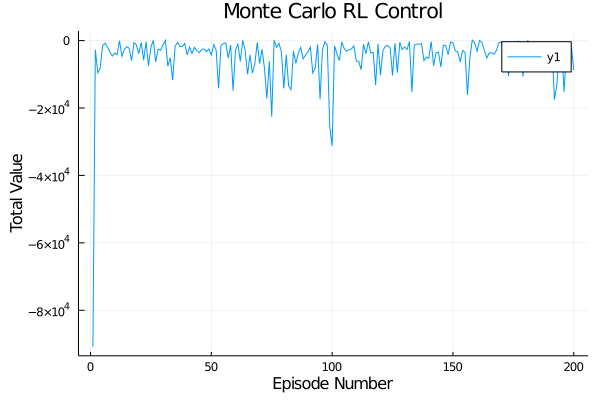

In [7]:
plot(1:length(mc_perf), mc_perf)
title!("Monte Carlo RL Control")
xlabel!("Episode Number")
ylabel!("Total Value")

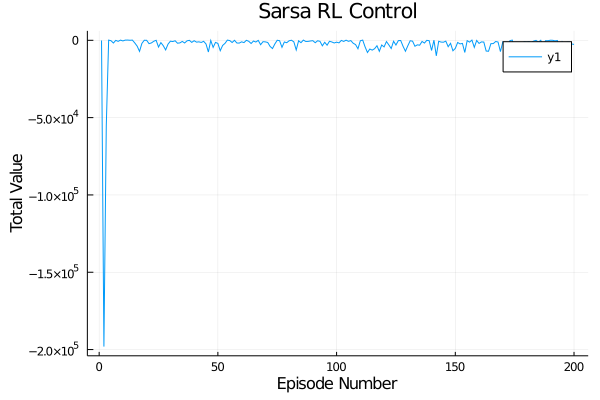

In [8]:
plot(1:length(sarsa_perf), sarsa_perf)
title!("Sarsa RL Control")
xlabel!("Episode Number")
ylabel!("Total Value")